## Utility functions and general imports

In [1]:
import h5py
import numpy as np
import scipy as scpy
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from scipy import optimize as opt
#from keras.utils import to_categorical

%matplotlib inline




In [46]:
# Defining utility functions for reading images and data in
def show_image(array, label):
    im = Image.fromarray(array)
    print("Item of label={}".format(label))
    return(imshow(im))

# Defining the sigmoid function required in LR
def sigmoid(z):
    return 1/(1+np.exp(-z))

# Vectorised cost function
def costFunctionReg(theta, X, y, lmbda):
    m = len(y)
    temp1 = np.multiply(y, np.log(sigmoid(np.dot(X, theta))))
    temp2 = np.multiply(1-y, np.log(1-sigmoid(np.dot(X, theta))))
    return np.sum(temp1 + temp2) / (-m) + np.sum(theta[1:]**2) * lmbda / (2*m)

# Vectorised gradient

def gradRegularization(theta, X, y, lmbda):
    m = len(y)
    temp = sigmoid(np.dot(X, theta)) - y
    temp = np.dot(temp.T, X).T / m + theta * lmbda / m
    temp[0] = temp[0] - theta[0] * lmbda / m
    return temp

def cost(theta, X, y):
    predictions = sigmoid(X @ theta)
    predictions[predictions == 1] = 0.999 # log(1)=0 causes error in division
    error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions);
    return sum(error) / len(y);

def cost_gradient(theta, X, y):
    predictions = sigmoid(X @ theta);
    return X.transpose() @ (predictions - y) / len(y)

def construct_conf_mat(actual_y, predicted_prob, pos_class_label, thresh=0.5):
    fp, tp, fn, tn = 0, 0, 0, 0
    for i in range(actual_y.shape[0]):
        if predicted_prob[i] >= thresh:
            if actual_y[i] == pos_class_label:
                tp += 1
            else:
                fp += 1
        else:
            if actual_y[i] == pos_class_label:
                fn += 1
            else:
                tn += 1
    return fp, tp, fn, tn

def add_intercept(X,y):
    m = len(y)
    ones = np.ones((m,1))
    
    X = np.concatenate((ones,X),axis=1)
    m,n = X.shape
    print(X.shape)
    return(X,n)


In [5]:
# Import the files in from python h5 format

with h5py.File('./Project1/data/images_training.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('./Project1/data/labels_training.h5','r') as H:
    label = np.copy(H['label'])
    

with h5py.File('./Project1/data/images_testing.h5','r') as H:
    data_test = np.copy(H['data'])
    
with h5py.File('./Project1/data/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['label'])    

## For reference: https://github.com/zalandoresearch/fashion-mnist



| Label | Description   |
|------|------|
|   0  | T-shirt/top|
|   1  | Trouser|
|   2  | Pullover|
|   3  | Dress|
|   4  | Coat|
|   5  | Sandal|
|   6  | Shirt|
|   7  | Sneaker|
|   8  | Bag|
|   9  | Ankle boot|

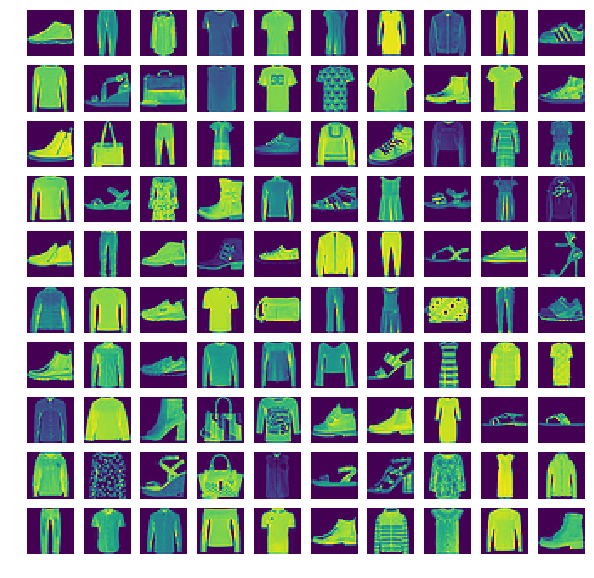

In [6]:
i = 10
#show_image(data[i],label[i])

#print('Total training data shape : ', data.shape, label.shape)
#data_train = data_train / 255


_, axarr = plt.subplots(10,10,figsize=(10,10))

for i in range(10):
    for j in range(10):
       axarr[i,j].imshow(data[np.random.randint(data.shape[0])].\
reshape((28,28), order = 'F'))          
       axarr[i,j].axis('off')     


## Exploratory Analysis

In [7]:
# How many unique classes are we dealing with? Do we need to perform any sampling for class imbalance?
classes = np.unique(label)
nclasses = len(classes)
print('Total number of classes : ', nclasses)
print('Classes to classify are : ', classes)

unique, counts = np.unique(label, return_counts=True)
print('Distribution of labels against total population:')
dict(zip(unique,counts))


Total number of classes :  10
Classes to classify are :  [0 1 2 3 4 5 6 7 8 9]
Distribution of labels against total population:


{0: 3011,
 1: 2956,
 2: 3020,
 3: 3002,
 4: 3029,
 5: 3028,
 6: 2967,
 7: 2895,
 8: 3002,
 9: 3090}

## Shaping the data ready to be processed

In [8]:
data.shape
# Creating a 80/20% split for the training data to be validated on
indices = range(data.shape[0])
training_records = int(0.8 * data.shape[0])


# Get the records that are part of the indices declared above
data_train = data[:training_records]
data_validate = data[training_records:]

# Get the labels that are part of the indices declared above
label_train = label[:training_records]
label_validate = label[training_records:]

data_train = data_train.reshape(-1, 784)
data_validate = data_validate.reshape(-1, 784)
#label_train = label_train.reshape(-1, 1)
label_train = np.squeeze(label_train)
label_validate = np.squeeze(label_validate)

# Standardise all of the input data
#data_train = data_train.astype('float32') /255

records = data_train.shape[0]
records_validate = data_validate.shape[0]
features = data_train.shape[1]
features_validate = data_validate.shape[1]

X = data_train
X_validate = data_validate
y = label_train
y_validate = label_validate

print(X.shape)
print(y.shape)
print(X_validate.shape)
print(y_validate.shape)


print('Total number of records in X train: {}'.format(records))
print('Total number of features in X train: {}'.format(features))

print('Total number of records in X train (valdation set): {}'.format(records_validate))
print('Total number of features in X train (validation set): {}'.format(features_validate))


(24000, 784)
(24000,)
(6000, 784)
(6000,)
Total number of records in X train: 24000
Total number of features in X train: 784
Total number of records in X train (valdation set): 6000
Total number of features in X train (validation set): 784


## Pre-processing and keeping relevant components/information of image

Item of label=0
Shape of lower dimension image (24000, 254):
Shape of reconstructed image (24000, 784):


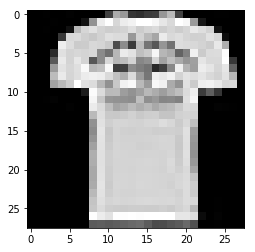

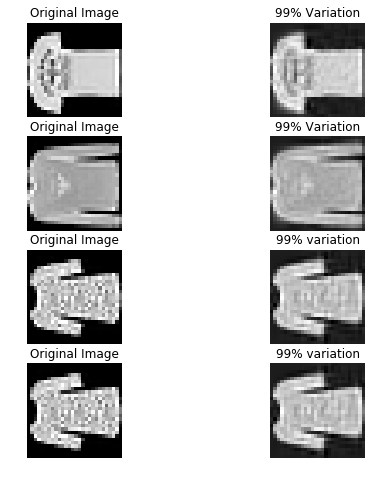

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

i = 0
show_image(data[i],label[i])

#Normalize data by subtracting mean and scaling
X_norm = normalize(data_train)

# Find the principal components that explain 99% of the data
pca = PCA(.95)

#Run PCA on normalized image data
lower_dim_data = pca.fit_transform(X_norm)
#Lower dimension data is 24000x254 instead of 24000*784
print('Shape of lower dimension image {}:'.format(lower_dim_data.shape))

#Project lower dimension data onto original features
approximation = pca.inverse_transform(lower_dim_data)
#Approximation is 
print('Shape of reconstructed image {}:'.format(approximation.shape))
#Reshape approximation and X_norm to 784*28*28 to display images
approximation = approximation.reshape(-1,28,28)
X_norm = X_norm.reshape(-1,28,28)


for i in range(0,X_norm.shape[0]):
    X_norm[i,] = X_norm[i,].T
    approximation[i,] = approximation[i,].T
fig4, axarr = plt.subplots(4,2,figsize=(8,8))
axarr[0,0].imshow(X_norm[0,],cmap='gray')
axarr[0,0].set_title('Original Image')
axarr[0,0].axis('off')
axarr[0,1].imshow(approximation[0,],cmap='gray')
axarr[0,1].set_title('99% Variation')
axarr[0,1].axis('off')
axarr[1,0].imshow(X_norm[1,],cmap='gray')
axarr[1,0].set_title('Original Image')
axarr[1,0].axis('off')
axarr[1,1].imshow(approximation[1,],cmap='gray')
axarr[1,1].set_title('99% Variation')
axarr[1,1].axis('off')
axarr[2,0].imshow(X_norm[2,],cmap='gray')
axarr[2,0].set_title('Original Image')
axarr[2,0].axis('off')
axarr[2,1].imshow(approximation[2,],cmap='gray')
axarr[2,1].set_title('99% variation')
axarr[2,1].axis('off')

axarr[3,0].imshow(X_norm[2,],cmap='gray')
axarr[3,0].set_title('Original Image')
axarr[3,0].axis('off')
axarr[3,1].imshow(approximation[2,],cmap='gray')
axarr[3,1].set_title('99% variation')
axarr[3,1].axis('off')
plt.show()

## Setting up terms, intercept and gradients for LogisticRegression - OVR

In [9]:
def add_intercept(X,y):
    m = len(y)
    ones = np.ones((m,1))
    
    X = np.concatenate((ones,X),axis=1)
    m,n = X.shape
    print(X.shape)
    return(X,n)

In [10]:
X,n = add_intercept(X,y)
X_validate, n = add_intercept(X_validate,y_validate)

(24000, 785)
(6000, 785)


## Finding the optimal weights and parameters for the 10 classes

In [39]:
#%%timeit -n 1 -r 1

lmbda = 0.5
k = 10
theta = np.zeros((k,n)) #inital parameters
for i in range(k):
    label_class = i if i else 0
    print('Class {} being optimised'.format(i))


    theta[i] = opt.fmin_cg(f = costFunctionReg, x0 = theta[i],  fprime = gradRegularization, args = (X,(y == label_class).flatten(), lmbda), maxiter = 200, disp = True)    

Class 0 being optimised


ValueError: shapes (24000,785) and (10,785) not aligned: 785 (dim 1) != 10 (dim 0)

In [44]:
def create_multiclass_c(X, n):


    for i in range(k):
        label_class = i if i else 0
        print('Class {} being optimised'.format(i))
        cost0 = cost(theta, X, (y==label_class.flatten()))
        #cost[i] = cost(theta[i], X,y)
        #print('Cost for Class {}:'.format(cost[i]))
        theta[i] = opt.fmin_cg(f = costFunctionReg, x0 = theta[i],  fprime = gradRegularization, args = (X,(y == label_class).flatten(), lmbda), maxiter = 200, disp = True)    

    return (theta)    
    

## Trying a different tack with gradient descent and cost/loss calculations

In [45]:
lmbda = 0.5
k = 10
theta = np.zeros((k,n)) #inital parameters

theta = create_multiclass_c(X,n)

Class 0 being optimised


AttributeError: 'int' object has no attribute 'flatten'

In [20]:
pred = []
pred = np.argmax(X @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred]
np.mean(pred == y.flatten()) * 100
#79.74166666666666

88.44583333333334

In [21]:
pred_validate = []
pred_validate = np.argmax(X_validate @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred]
np.mean(pred_validate == y_validate.flatten()) * 100
#79.74166666666666

83.63333333333334

In [22]:
print(pred_validate)
print(y_validate)

[1 5 9 ... 3 1 4]
[1 5 9 ... 3 1 2]
